In [2]:
import keras
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


<h4> MNIST Dataset</h4>

<p>
    Keras conveniently provides the classic 
    <a href='https://en.wikipedia.org/wiki/MNIST_database'>mnist dataset</a> 
    by simple function call. MNIST is a collection of gray-scale images of handwritten digits (0-9). Our task will be to build a classifier that can 'read' these pictures of handwritten inputs and guess the corresponding numerical representation. Before doing anything fancy lets load in the data and take a look.
</p>


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

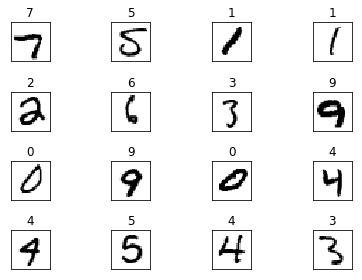

In [4]:
#Let's plot 16 random images and their answers

#Select random images
select_images = np.random.randint(0, y_train.shape[0], 16)

#plot them

fig, axes = plt.subplots(nrows=4, ncols=4)

for i, ax in zip(select_images,axes.flatten()):
    ax.imshow(x_train[i], cmap=plt.cm.binary)
    ax.set_title(y_train[i])
    ax.xaxis.set_visible(False) ; ax.yaxis.set_visible(False)
plt.tight_layout()

<h5>Simple Feed forward Neural Network</h5>

<p>Layers in a feed forward Neural Network are really just matrix multiplications. Shapes matter in matrix multiplication, so we need to first define the shapes of our inputs and outputs to each layer. </p>
<p>The MNIST dataset consists of 28x28 dimensional images, so first lets define an Input layer that takes a 28 x 28 dimensional arrays for each training example. See documentation in <b>keras.layers.Input</b> for details on how to construct this input layer.</p>


In [5]:
#Create an input layer here
input_tensor = keras.layers.Input( shape=x_train.shape[1:] )

<p>Our input layer returns a computational tensor. You can think of this tensor as being a variable or placeholder representing (N x 28 x 28) dimensional input where N is the batch size. We will use this input to construct a computational graph, that through basic algebraic manipulation, will eventually transform our (N x 28 x 28) dimensional input into a (Nx10) output of predictions.</p>

<p>As a first exercise, lets implement logistic regression using keras! We will be using the functional programming style to implement our model. In this style of programming we instantiate and call a Layer  <a href='https://en.wikipedia.org/wiki/Function_object'>functor object</a> (found in the path keras.layers)  like so:
  
    <center>new_tensor = keras.layers.LayerObject1( \*\*args )(<b><i>input_tensor</i></b> )</center> 
</p>

<p>The output tensor of this transformation can undergo further transformations by passing it additional Layer functors like so:
    <p>
    <center>output = keras.layers.LayerObject2( \*\*args )( <b><i>new_tensor</i></b> )</center></p> 
</p>
<p>
For logistic regression we will use 3 types of layers:
<ol>
    <li><b>keras.layers.Flatten</b> -- to first transform our (Nx28x28) inputs into (N x 784) outputs.</li>
    <li><b>keras.layers.BatchNormalization</b> -- to standardize all our inputs to have unit norm and standard deviation.
    </li>
    <li><b>keras.layers.Dense</b> -- to apply the matrix multiplication that will learn the best matrix of weights for converting an (N x 784) dimensional matrix into a (N x 10) dimensional array of outputs. (Considering the rules of linear algebra, how many weights dose this layer need to 'learn'?) </li>
</ol>
As a convenience the keras.layers.Dense object accepts the keyword argument <i>activation</i> that will apply the desired activation function to the layer outputs. Keras built in activation functions can be found under <b>keras.activations</b>. For logistic regression we use the <a href='https://en.wikipedia.org/wiki/Softmax_function'>softmax activation function</a>. Try implementing this feed forward NN using keras documentation for the three layer objects we listed above.
</p>



In [6]:
#Implement the layer feed forward NN outlined above, below:
x     = keras.layers.Flatten()(input_tensor)
x     = keras.layers.BatchNormalization(axis=-1)(x)
x     = keras.layers.Dense(10,activation=keras.activations.softmax)(x)

To turn this sequence of transformational steps on variable tensors into a data processing pipeline that will learn from and transform actual data, we need to create and compile a keras model object. The keras module object constructor takes a list of tensor objects as inputs and a list of tensor objects that will be the model output as outputs. We will instantiate our model and print a summary below:

In [7]:
model = keras.models.Model(inputs=[input_tensor], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 10,986
Trainable params: 9,418
Non-trainable params: 1,568
_________________________________________________________________


Now we will compile our keras model using the Model member function <i>compile</i>. As arguments, compilation takes: 

<ol>
<li>A keras optimizer object that will preform the gradient descent. See keras.optimizers . (ADAM is good general choice.) </li>
<li>A loss function (or dictionary of loss functions) the optimizer will seek to minimize. See keras.losses</li>
<li>A metric or list of metrics (optional) for monitoring how the model preforms during training. See keras.metrics</li>
</ol>

In [8]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss = keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy]
             )


In [9]:
history = model.fit(
                x=x_train, 
                y=keras.utils.to_categorical(y_train), 
                batch_size=1000,
                epochs=10,
                validation_data=(x_test, keras.utils.to_categorical(y_test)),
                verbose=0
            )

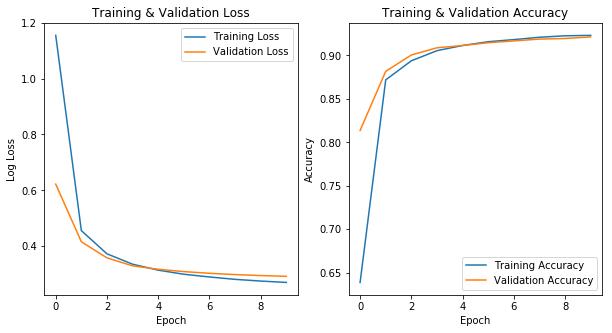

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epoch')
plt.title('Training & Validation Loss')


plt.subplot(122)
plt.plot(history.epoch, history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training & Validation Accuracy')

plt.show()

In [11]:
#Use trained model to generate predictions for all test set images
predictions = model.predict(x_test)

<h2>Lets Take A Closer Look</h2>

In [12]:
def visualize_preformance(x, guess, true, indx):
    plt.subplot(121)
    plt.bar(range(10),guess[indx])
    plt.xticks([v for v in range(10)])
    plt.ylabel('Probability')
    plt.title( "Prediction: %i" %(np.argmax(guess[indx])) )

    plt.subplot(122)
    plt.title("True value: %i"%(true[indx]))
    plt.imshow(x[indx], cmap=plt.cm.binary)
    plt.xticks([]); plt.yticks([])


<h5>Look At One We Got Right</h5> 

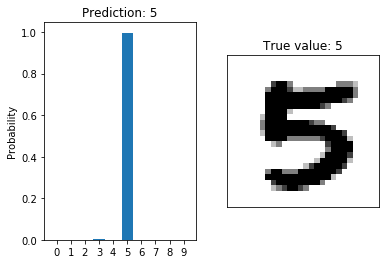

In [13]:
correct = np.argwhere( np.argmax(predictions,axis=1) == y_test).flatten()
indx = np.random.choice(correct)

visualize_preformance(x_test, predictions,y_test, indx)

<h5>Now Look At A Randomly Selected Mistake</h5>

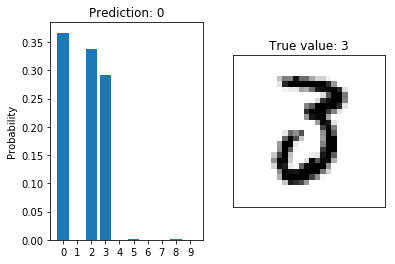

In [14]:
wrong = np.argwhere( np.argmax(predictions,axis=1) != y_test).flatten()
indx = np.random.choice(wrong)

visualize_preformance(x_test, predictions,y_test, indx)

<h2>Convolutional Neural Network</h2>

In [15]:
image = keras.layers.Input( shape=x_train.shape[1:] )

x = keras.layers.Reshape((28,28,1))(image)

x = keras.layers.BatchNormalization(axis=-1)(x)

x = keras.layers.Conv2D(16,(5,5),padding='valid', activation=keras.activations.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2,2),padding='valid')(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(1024, activation=keras.activations.relu)(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(10, activation=keras.activations.softmax)(x)

In [16]:
model=keras.models.Model(inputs=[image], outputs=[x])

model.compile(optimizer=keras.optimizers.Adam(),
              loss = keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy]
             )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
__________

In [17]:
history = model.fit(
                x=x_train, 
                y=keras.utils.to_categorical(y_train), 
                batch_size=1000,
                epochs=15,
                validation_data=(x_test, keras.utils.to_categorical(y_test)),
                verbose=1
            )

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 36s 596us/step - loss: 0.5871 - categorical_accuracy: 0.8397 - val_loss: 0.3566 - val_categorical_accuracy: 0.8990
Epoch 2/15
60000/60000 [==============================] - 35s 587us/step - loss: 0.2579 - categorical_accuracy: 0.9233 - val_loss: 0.2991 - val_categorical_accuracy: 0.9353
Epoch 3/15
60000/60000 [==============================] - 34s 563us/step - loss: 0.1915 - categorical_accuracy: 0.9418 - val_loss: 0.2637 - val_categorical_accuracy: 0.9494
Epoch 4/15
60000/60000 [==============================] - 32s 536us/step - loss: 0.1570 - categorical_accuracy: 0.9511 - val_loss: 0.1596 - val_categorical_accuracy: 0.9705
Epoch 5/15
60000/60000 [==============================] - 32s 534us/step - loss: 0.1364 - categorical_accuracy: 0.9570 - val_loss: 0.1211 - val_categorical_accuracy: 0.9751
Epoch 6/15
60000/60000 [==============================] - 32s 530us/step - loss: 0.12

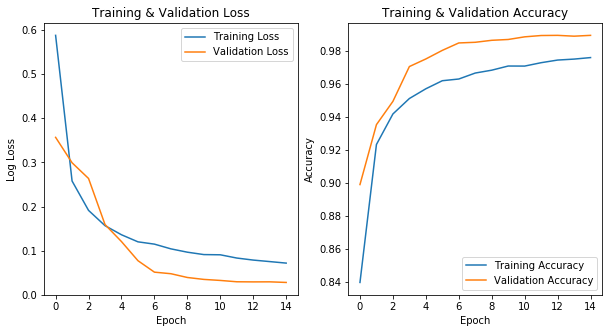

In [18]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epoch')
plt.title('Training & Validation Loss')


plt.subplot(122)
plt.plot(history.epoch, history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training & Validation Accuracy')

plt.show()

Not bad, certainly beats the piddling 92% we were getting with the dense layer! Lets try decreasing the learning rate.

In [19]:
model.optimizer.lr = .1*model.optimizer.lr

history2 = model.fit(
                x=x_train, 
                y=keras.utils.to_categorical(y_train), 
                batch_size=1000,
                epochs=10,
                validation_data=(x_test, keras.utils.to_categorical(y_test)),
                verbose=1
            )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 533us/step - loss: 0.0711 - categorical_accuracy: 0.9765 - val_loss: 0.0277 - val_categorical_accuracy: 0.9899
Epoch 2/10
60000/60000 [==============================] - 32s 529us/step - loss: 0.0685 - categorical_accuracy: 0.9775 - val_loss: 0.0279 - val_categorical_accuracy: 0.9909
Epoch 3/10
60000/60000 [==============================] - 32s 533us/step - loss: 0.0661 - categorical_accuracy: 0.9784 - val_loss: 0.0278 - val_categorical_accuracy: 0.9906
Epoch 4/10
60000/60000 [==============================] - 32s 528us/step - loss: 0.0667 - categorical_accuracy: 0.9785 - val_loss: 0.0257 - val_categorical_accuracy: 0.9909
Epoch 5/10
60000/60000 [==============================] - 32s 532us/step - loss: 0.0634 - categorical_accuracy: 0.9794 - val_loss: 0.0255 - val_categorical_accuracy: 0.9909
Epoch 6/10
60000/60000 [==============================] - 32s 531us/step - loss: 0.06